In [1]:
from SCA_classes import Segmentation_Collision_Avoidance, Debug_Timer
import numba_functs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import cv2
import time
import yaml
from ultralytics import FastSAM
from collections import defaultdict
from shapely.geometry import Point, Polygon
from numba import njit, prange
from timeit import default_timer as timer
from PIL import Image
from scipy import stats

In [2]:
sca = Segmentation_Collision_Avoidance("config")

In [3]:
# for i in range(10):
#     sca.add_CARLA_image_file("1080p" + str(i + 40))

for i in range(6):
    sca.add_OAKD_image_file(str(i + 73))

# for i in range(6): # 2, 6
#     sca.add_OAKD_image_file("2_" + str(i + 69))

/home/linden/anaconda3/envs/FastSAM/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


0: 384x640 100 objects, 86.3ms
Speed: 4.5ms preprocess, 86.3ms inference, 43.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 79 objects, 56.0ms
Speed: 1.5ms preprocess, 56.0ms inference, 43.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 78 objects, 66.3ms
Speed: 4.0ms preprocess, 66.3ms inference, 45.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 68 objects, 53.5ms
Speed: 1.6ms preprocess, 53.5ms inference, 42.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 67 objects, 75.3ms
Speed: 1.6ms preprocess, 75.3ms inference, 41.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 71 objects, 75.3ms
Speed: 1.6ms preprocess, 75.3ms inference, 60.4ms postprocess per image at shape (1, 3, 384, 640)


In [4]:
Debug_Timer.print_all()

open_img:
	avg = 0.01225226620833079, min = 0.010727046988904476, max = 0.018870998173952103
	total = 0.07351359724998474, 6 samples
fastSAM:
	avg = 0.2922526119897763, min = 0.14616578025743365, max = 0.9218249549157917
	total = 1.7535156719386578, 6 samples
clean_objects:
	avg = 0.05272788771738609, min = 0.04716153396293521, max = 0.06479596626013517
	total = 0.3163673263043165, 6 samples
make_cartesian:
	avg = 0.49478973300817114, min = 0.48890179488807917, max = 0.508504981175065
	total = 2.9687383980490267, 6 samples
add_OAKD_image_file:
	avg = 1.0069551800067227, min = 0.8466186900623143, max = 1.678079279139638
	total = 6.041731080040336, 6 samples


In [5]:
frame_idx = 1
window = sca.predictor.window
frame = window.frames[frame_idx]

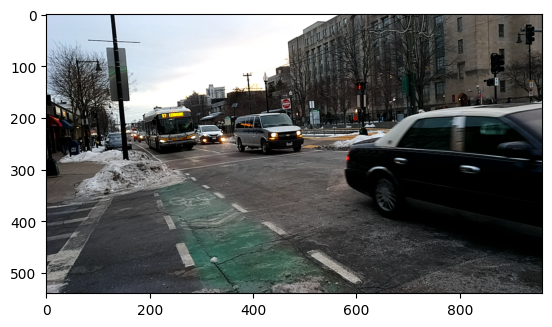

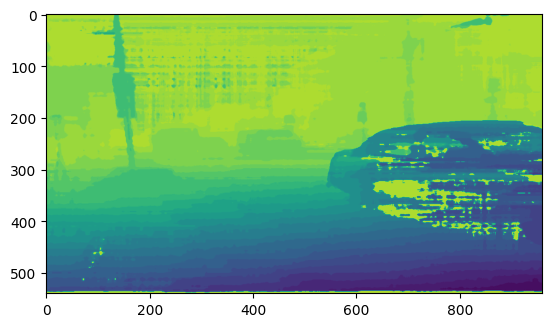

In [6]:
plt.imshow(frame.rgbImg)
plt.figure()
plt.imshow(frame.depthImg)
# [vertical, horizontal]

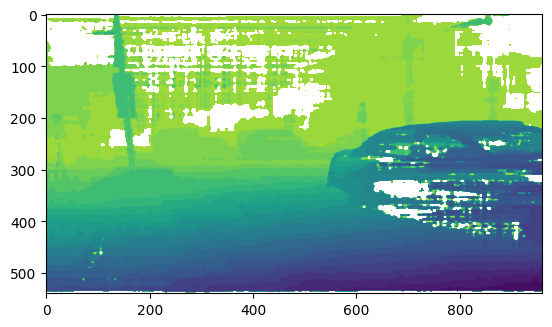

In [7]:
magic_idk_number = 9.125
plt.imshow(np.where(frame.depthImg == magic_idk_number, np.nan, frame.depthImg))

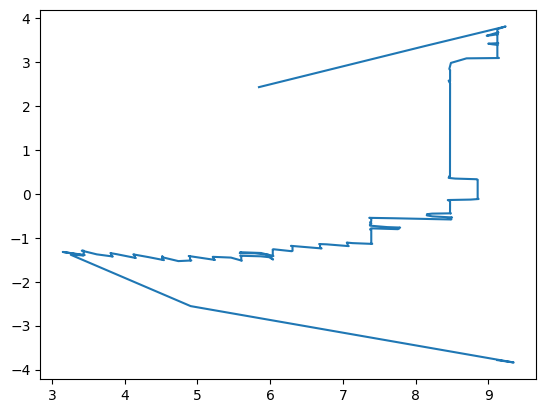

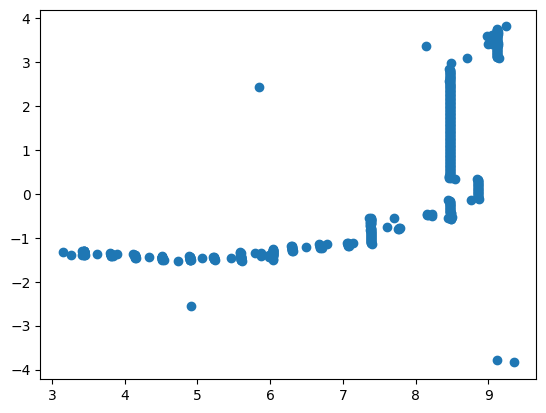

In [8]:
column = 600
lda = .02
min_g_size = 3
num_p = frame.depthImg[:,column].size
groups = np.zeros([num_p, 3])
groups[:,0:2] = np.asarray([frame.depthImg[:,column], frame.cartImg[:,column,1]]).T
centers = np.zeros(groups.shape + np.array([0,1]))
num_g = 0
g_size = 1
num_duds = 0
y_max = groups[0,0]
y_min = groups[0,0]
running_sum = np.zeros(2)
for i in range(num_p - 1):
    # distance = (groups[i + 1,0] - groups[i,0]) ** 2 + (groups[i + 1,1] - groups[i,1])
    distance = abs(groups[i + 1,0] - groups[i,0])
    # if distance > lda ** 2:
    if distance > lda:
        centers[num_g,0:2] = running_sum / g_size
        centers[num_g,2] = y_max - y_min
        centers[num_g,3] = g_size
        num_g = num_g + 1
        if g_size < min_g_size:
            centers[num_g - 1,0:2] = [np.nan] * 2
            groups[i,2] = -1
            num_duds = num_duds + 1
        running_sum = [0, 0]
        y_max = y_min = 0
        g_size = 0
    y_max = max(y_max, groups[i + 1,0])
    y_min = min(y_min, groups[i + 1,0])
    running_sum = running_sum + groups[i + 1,0:2]
    groups[i + 1,2] = num_g
    g_size = g_size + 1
num_g - num_duds

plt.plot(frame.depthImg[:,0], frame.cartImg[:,1,1])
plt.figure()
plt.scatter(frame.depthImg[:,0], frame.cartImg[:,1,1])

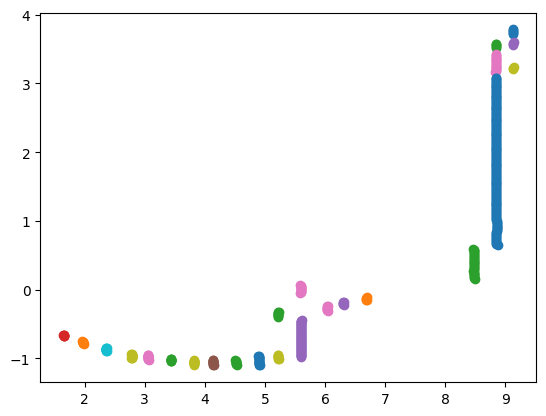

In [9]:
for i in range(num_g - 1, 0, -1):
    plt.scatter(groups[groups[:,2] == num_g - i - 1,0], groups[groups[:,2] == num_g - i - 1,1])

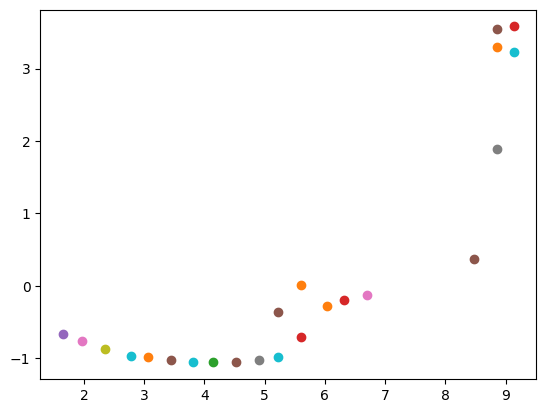

In [10]:
for i in range(num_g - 1, 0, -1):
    plt.scatter(centers[i,0], centers[i,1])

In [11]:
def find_ground(column):
    # column = 400
    lda = .1
    min_g_size = 3
    max_dist = .5
    max_angle = .5
    
    num_p = frame.depthImg[:,column].size
    groups = np.zeros([num_p, 3])
    groups[:,0:2] = np.asarray([frame.depthImg[:,column], frame.cartImg[:,column,1]]).T
    num_g = 0
    g_size = 1
    num_duds = 0
    get_rid = np.zeros(num_p) - 1
    correct = np.ones(num_p, dtype=bool)

    for i in range(num_p):
        if(i != num_p - 1):
            distance = abs(groups[i + 1,0] - groups[i,0])
        else:
            distance = lda * 2
        if distance > lda:
            if g_size < min_g_size:
                get_rid[num_duds] = num_g
                num_duds = num_duds + 1
            num_g = num_g + 1
            g_size = 0
        if(i != num_p - 1):
            groups[i + 1,2] = num_g
        g_size = g_size + 1

    duds_i = 0
    for i in range(num_p):
        g = groups[i, 2]
        if(g > get_rid[duds_i]):
            duds_i = duds_i + 1
        if(g == get_rid[duds_i]):
            correct[i] = False

    groups = groups[correct,:]

    # plt.scatter(groups[:,0], groups[:,1])

    centers = np.zeros([groups.shape[0],2])
    num_g = 0
    g_size = 1
    running_sum = groups[0,0:2]
    for i in range(groups.shape[0] - 1):
        distance = abs(groups[i + 1,0] - running_sum[0] / g_size)
        if distance > lda:
            centers[num_g,0:2] = running_sum / g_size
            num_g = num_g + 1
            running_sum = [0, 0]
            g_size = 0
        running_sum = running_sum + groups[i + 1,0:2]
        g_size = g_size + 1
    running_sum = running_sum + groups[i + 1,0:2]
    g_size = g_size + 1
    centers[num_g,0:2] = running_sum / g_size

    centers = centers[:num_g + 1,:][::-1,:]
    # for i in range(num_g):
    #     plt.scatter(centers[i,0], centers[i,1])
    for i in range(num_g - 2):
        dist1 = np.sum(np.square(centers[i,:] - centers[i + 1,:]))
        dist2 = np.sum(np.square(centers[i + 1,:] - centers[i + 2,:]))
        angle1 = math.acos(abs(centers[i,0] - centers[i + 1,0])**2 / dist1)
        angle2 = math.acos(abs(centers[i + 1,0] - centers[i + 2,0])**2 / dist2)
        if dist2 > max_dist or abs(angle1 - angle2) > max_angle:
            done = i + 1
            break

    groups = np.asarray([frame.depthImg[:,column], frame.cartImg[:,column,1]]).T
    mini = 100
    c = centers[done]
    for i in range(groups.shape[0]):
        dist = np.sum(np.square(c - groups[i,:]))
        if dist < mini:
            mini = dist
            idx = i

    return idx

# plt.scatter(centers[:,0], centers[:,1])
# plt.scatter(centers[:done + 1,0], centers[:done + 1,1])
# plt.scatter(centers[done,0], centers[done,1])
# plt.scatter(groups[idx,0], groups[idx,1])

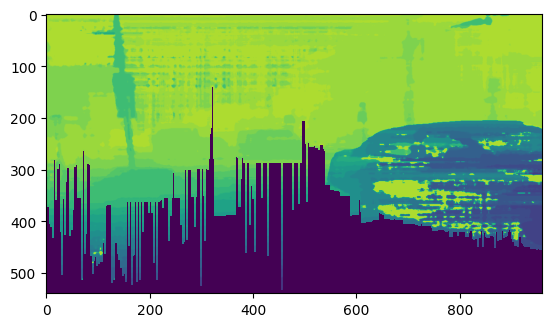

In [12]:
f = frame.depthImg
plt.imshow(f)
fy = f.shape[0] - 1
fx = f.shape[1]
ground = np.ones(f.shape, dtype=bool)
for col in range(fx):
    g = find_ground(col)
    ground[g:,col] = False
    # plt.plot([col,col],[g,fy])
ground = np.where(ground == 1, np.nan, 0)
plt.imshow(ground)

# TODO: fix is to allow placement into current and last group to allow for double backs
# oh also filter points from start

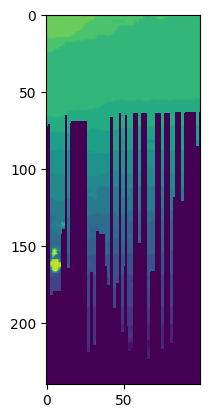

In [13]:
plt.imshow(f[300:,100:200])
plt.imshow(ground[300:,100:200])

0.15529312004262733 0.13691954993984293 0.12337913247577392
0.13691954993984293 0.1048428895643808 0.061938691294900136
0.1048428895643808 0.14677969355751733 0.05355986851697194
0.14677969355751733 0.14146907264697703 0.07772132495389356
0.14146907264697703 0.12041762591816119 0.11138235262348846
0.12041762591816119 0.1295041697044158 0.36890442269954904
0.1295041697044158 0.09982183328383976 0.4322513802382782
0.09982183328383976 0.14441429812089918 0.11686585096740812
0.14441429812089918 0.19424405806261805 0.03971219890163809
0.19424405806261805 0.07447952459865109 0.22956388994733046
0.07447952459865109 0.1461504778901235 0.020477677152578366
0.1461504778901235 0.15789022256832536 0.14883786091591128
0.15789022256832536 0.23884958476748847 0.6964252544980541
364


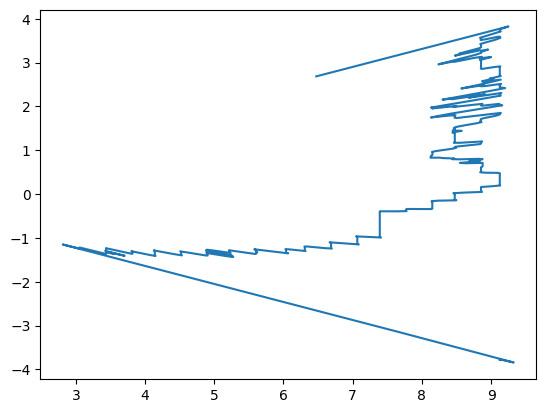

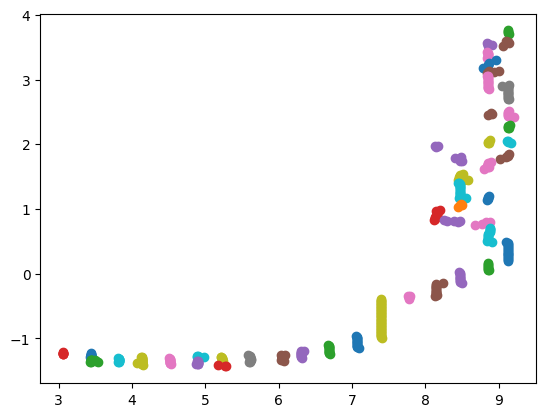

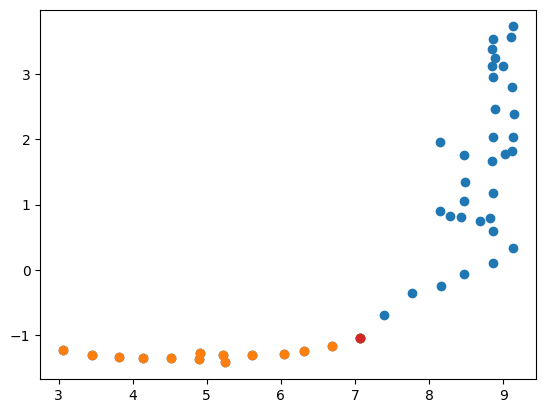

In [14]:
column = 176

lda = .1
min_g_size = 3
max_dist = .5
max_angle = .5
num_p = frame.depthImg[:,column].size
groups = np.zeros([num_p, 3])
groups[:,0:2] = np.asarray([frame.depthImg[:,column], frame.cartImg[:,column,1]]).T
plt.plot(groups[:,0], groups[:,1])
num_g = 0
g_size = 1
num_duds = 0
get_rid = np.zeros(num_p) - 1
correct = np.ones(num_p, dtype=bool)

for i in range(num_p):
    if(i != num_p - 1):
        distance = abs(groups[i + 1,0] - groups[i,0])
    else:
        distance = lda * 2
    if distance > lda:
        if g_size < min_g_size:
            get_rid[num_duds] = num_g
            num_duds = num_duds + 1
        num_g = num_g + 1
        g_size = 0
    if(i != num_p - 1):
        groups[i + 1,2] = num_g
    g_size = g_size + 1

duds_i = 0
for i in range(num_p):
    g = groups[i, 2]
    if(g > get_rid[duds_i]):
        duds_i = duds_i + 1
    if(g == get_rid[duds_i]):
        correct[i] = False

groups = groups[correct,:]

plt.figure()
for i in range(num_g - 1, 0, -1):
    plt.scatter(groups[groups[:,2] == num_g - i - 1,0], groups[groups[:,2] == num_g - i - 1,1])

centers = np.zeros([groups.shape[0],2])
num_g = 0
g_size = 1
running_sum = groups[0,0:2]
for i in range(groups.shape[0] - 1):
    distance = abs(groups[i + 1,0] - running_sum[0] / g_size)
    if distance > lda:
        centers[num_g,0:2] = running_sum / g_size
        num_g = num_g + 1
        running_sum = [0, 0]
        g_size = 0
    running_sum = running_sum + groups[i + 1,0:2]
    g_size = g_size + 1
running_sum = running_sum + groups[i + 1,0:2]
g_size = g_size + 1
centers[num_g,0:2] = running_sum / g_size

centers = centers[:num_g + 1,:][::-1,:]
# for i in range(num_g):
#     plt.scatter(centers[i,0], centers[i,1])
for i in range(num_g - 2):
    dist1 = np.sum(np.square(centers[i,:] - centers[i + 1,:]))
    dist2 = np.sum(np.square(centers[i + 1,:] - centers[i + 2,:]))
    angle1 = math.acos(abs(centers[i,0] - centers[i + 1,0])**2 / dist1)
    angle2 = math.acos(abs(centers[i + 1,0] - centers[i + 2,0])**2 / dist2)
    print(dist1, dist2, abs(angle1 - angle2))
    if dist2 > max_dist or abs(angle1 - angle2) > max_angle:
        done = i + 1
        break

groups = np.asarray([frame.depthImg[:,column], frame.cartImg[:,column,1]]).T
mini = 100
c = centers[done]
for i in range(groups.shape[0]):
    dist = np.sum(np.square(c - groups[i,:]))
    if dist < mini:
        mini = dist
        idx = i
print(idx)

plt.figure()
plt.scatter(centers[:,0], centers[:,1])
plt.scatter(centers[:done + 1,0], centers[:done + 1,1])
plt.scatter(centers[done,0], centers[done,1])
plt.scatter(groups[idx,0], groups[idx,1])

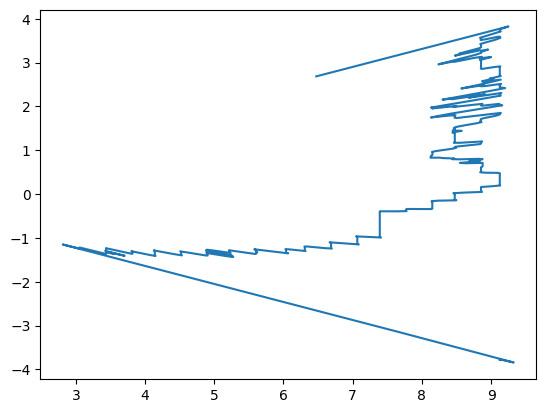

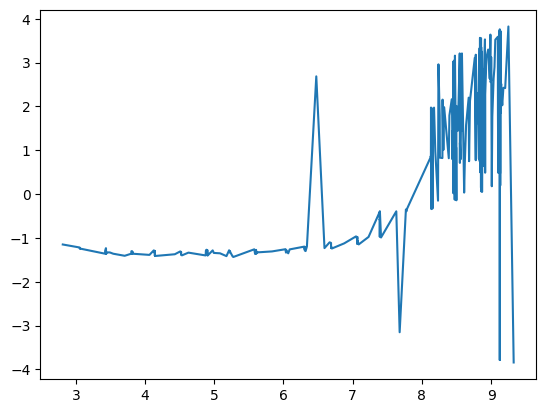

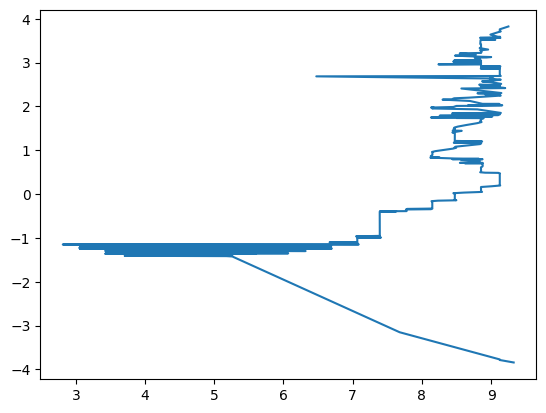

In [15]:
groups[:,0:2] = np.asarray([frame.depthImg[:,column], frame.cartImg[:,column,1]]).T
plt.plot(groups[:,0], groups[:,1])
plt.figure()
groups = groups[groups[:, 0].argsort()]
plt.plot(groups[:,0], groups[:,1])
plt.figure()
groups = groups[groups[:, 1].argsort()]
plt.plot(groups[:,0], groups[:,1])

In [16]:
print(frame.depthImg[300,600])
print(frame.depthImg[100,100])

6.03731
8.444678


/tmp/ipykernel_1249878/3253097675.py:7: RuntimeWarning: invalid value encountered in cast
  rgbImg[:,:,i] = np.where(obj.segMask, rgbImg[:,:,i], np.nan)
/tmp/ipykernel_1249878/3253097675.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


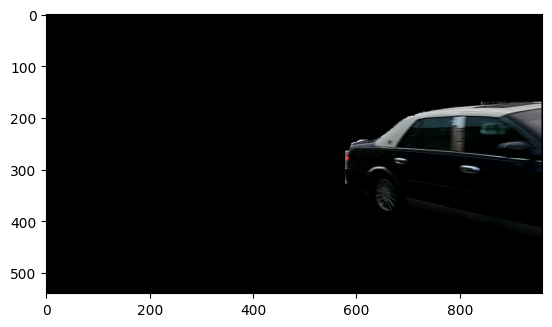

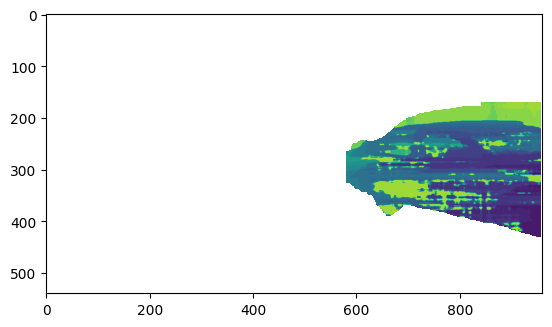

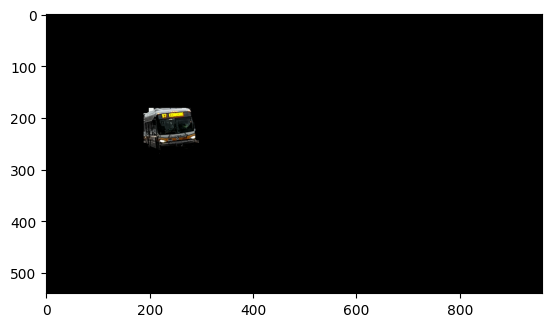

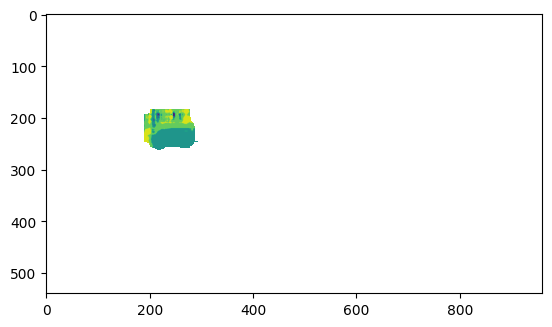

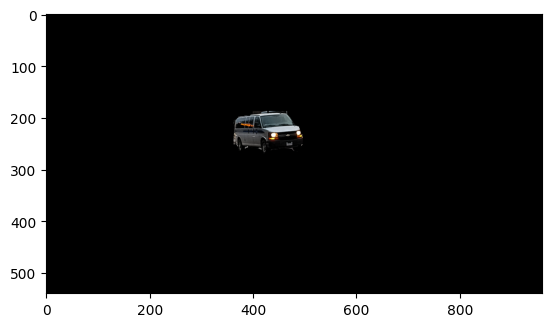

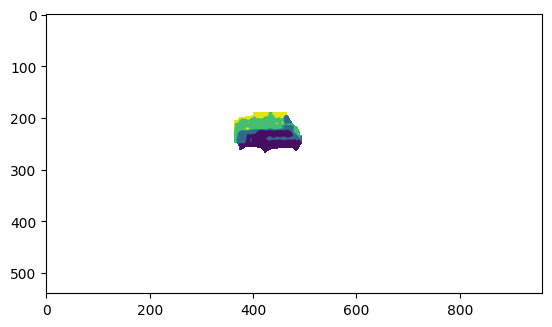

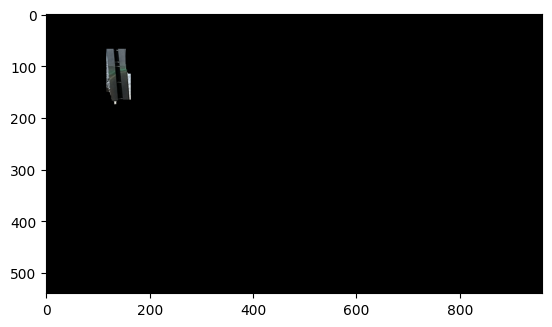

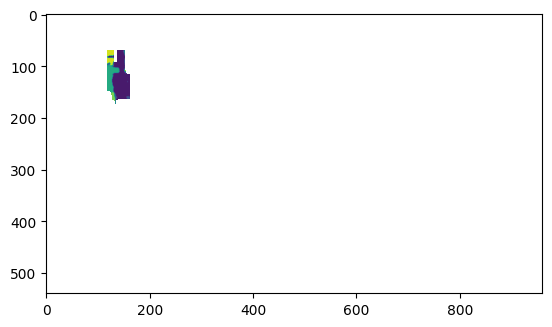

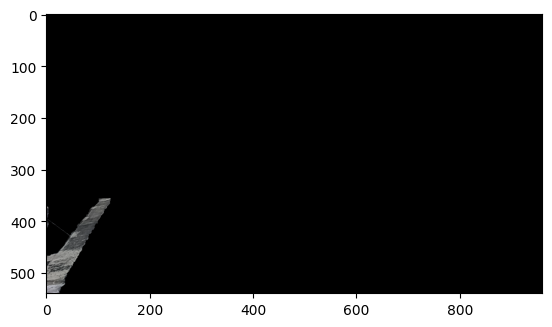

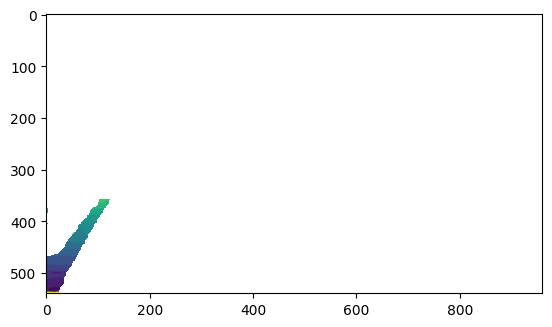

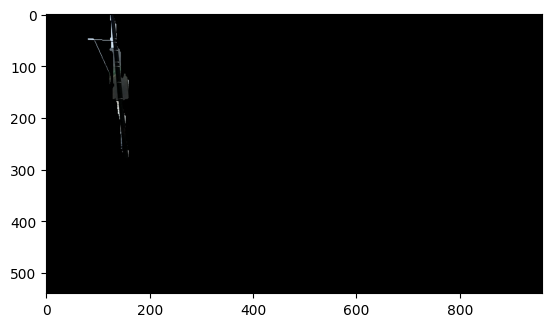

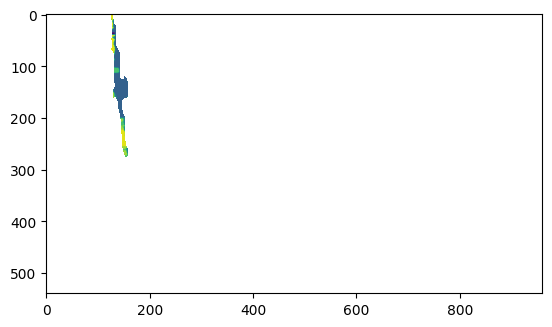

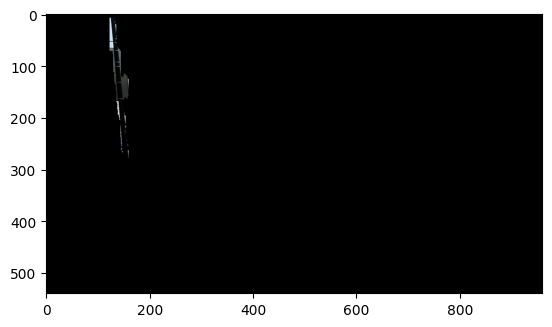

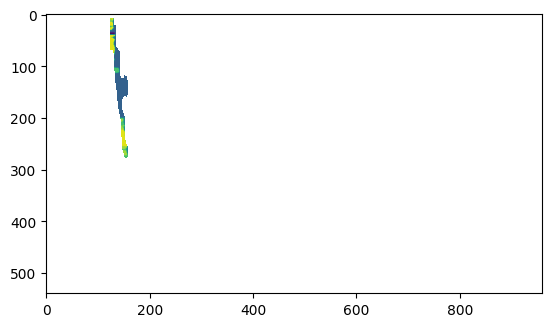

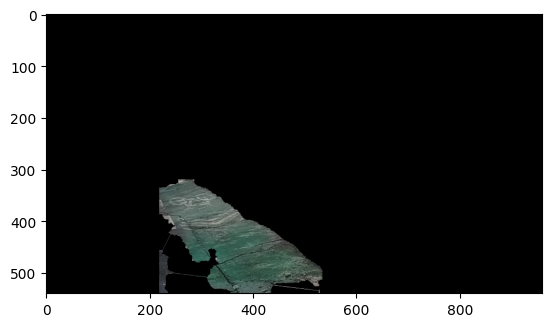

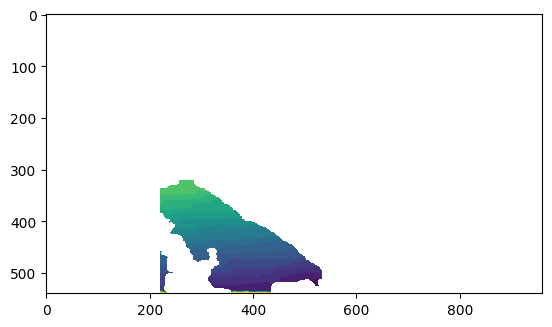

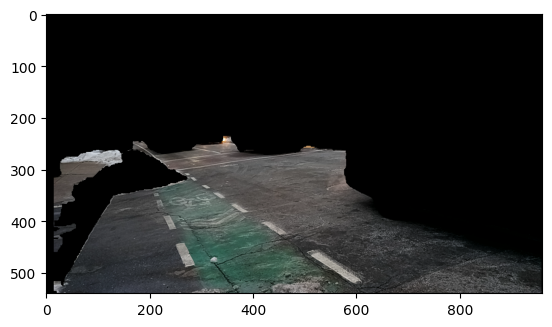

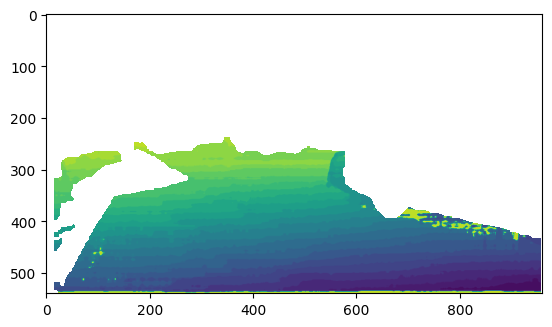

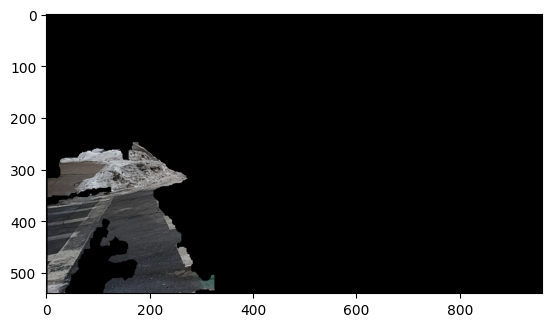

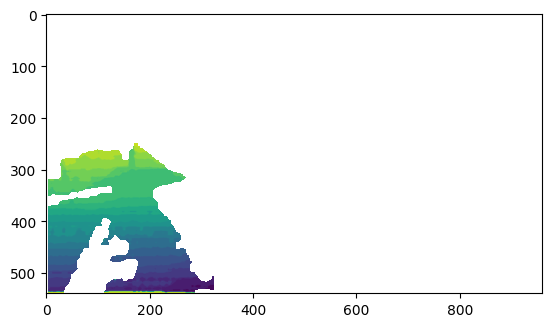

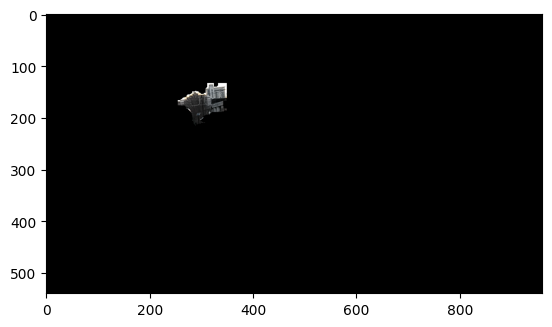

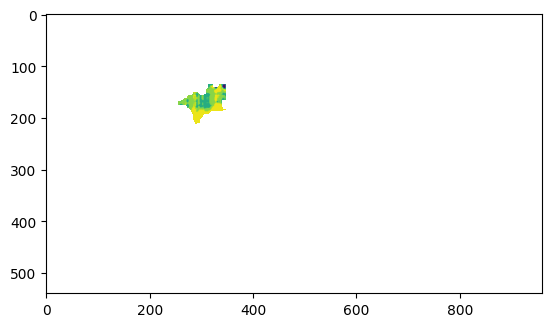

In [17]:
window = sca.predictor.window
frame = window.frames[frame_idx]
for obj in window.objects_in_scope[frame_idx]:
    rgbImg = np.copy(frame.rgbImg)
    depthImg = np.copy(frame.depthImg)
    for i in range(3):
        rgbImg[:,:,i] = np.where(obj.segMask, rgbImg[:,:,i], np.nan)
    depthImg[:,:] = np.where(obj.segMask, depthImg[:,:], np.nan)
    plt.figure()
    plt.imshow(rgbImg)
    plt.figure()
    plt.imshow(depthImg)